# Project 4: West Nile Virus Prediction
____________

#  Preprocessing & Modelling

Preprocess the cleaned dataset and find the best model.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import geopy.distance

import pickle

pd.set_option('display.max_columns', None)

## Read cleaned dataset

In [2]:
# read trap dataset
train = pd.read_csv('../assets/train.csv', parse_dates=['Date'], na_values=None)
test = pd.read_csv('../assets/test.csv', parse_dates=['Date'], na_values=None)
spray = pd.read_csv('../assets/spray.csv', parse_dates=['Date'], na_values=None)
weather = pd.read_csv('../assets/weather.csv', parse_dates=['Date'], na_values = ['M','-'])

In [3]:
df_train = pd.read_csv('../assets/cleaned_train.csv')
df_test = pd.read_csv('../assets/cleaned_test.csv')
df_spray = pd.read_csv('../assets/cleaned_spray.csv')
df_weather = pd.read_pickle(r'../assets/clean_weather.pk1')
df_train_test = pd.read_csv('../assets/cleaned_train_test.csv')

In [4]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,month,year
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,29,5,2007
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,29,5,2007
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,1,0,29,5,2007
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0,29,5,2007
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,1,0,29,5,2007


## Pre-processing and Feature engineering

### Location Features

We shall look at the location features. 

In [5]:
location = df_train[['Address','Block','Street','AddressNumberAndStreet','Latitude','Longitude']]

In [6]:
location.head()

,Address,Block,Street,AddressNumberAndStreet,Latitude,Longitude
0,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224
1,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224
2,"1100 South Peoria Street, Chicago, IL 60608, USA",11,S PEORIA ST,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860
3,"1100 West Chicago Avenue, Chicago, IL 60642, USA",11,W CHICAGO,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232
4,"1500 North Long Avenue, Chicago, IL 60651, USA",15,N LONG AVE,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886


As the latitude and longitude defines the locations, we will be dropping the rest of the features.

In [7]:
#As we will be using lat and long for location, the following features will be removed.
df_train.drop(columns=['Address','AddressNumberAndStreet','AddressAccuracy'],inplace=True)

In [8]:
df_train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    3826
CULEX RESTUANS            2393
CULEX PIPIENS             1950
CULEX TERRITANS            216
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [9]:
df_train.head()

,Date,Species,Block,Street,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,day,month,year
0,2007-05-29,CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,41.867108,-87.654224,1,0,29,5,2007
1,2007-05-29,CULEX RESTUANS,11,W ROOSEVELT,T048,41.867108,-87.654224,2,0,29,5,2007
2,2007-05-29,CULEX RESTUANS,11,S PEORIA ST,T091,41.862292,-87.648860,1,0,29,5,2007
3,2007-05-29,CULEX RESTUANS,11,W CHICAGO,T049,41.896282,-87.655232,1,0,29,5,2007
4,2007-05-29,CULEX RESTUANS,15,N LONG AVE,T153,41.907645,-87.760886,1,0,29,5,2007


In [10]:
df_train_new = df_train.groupby(['Date','day','month','year','Species','Trap','Latitude',
                            'Longitude','WnvPresent'], as_index=False).sum().reindex()

In [11]:
df_train_new.head()

,Date,day,month,year,Species,Trap,Latitude,Longitude,WnvPresent,Block,NumMosquitos
0,2007-05-29,29,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,0,22,1
1,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0,41,1
2,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,0,79,1
3,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0,11,1
4,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,0,21,1


### Convert Species into numbers

In [12]:
df_train_new['species_no'] = df_train_new['Species'].map({'CULEX PIPIENS/RESTUANS': 2,'CULEX PIPIENS': 2,'CULEX RESTUANS': 1})
df_train_new['species_no'].fillna(value=0,inplace=True)

In [13]:
# Occurrences in species type
df_train_new['species_no'].value_counts()

2.0    5776
1.0    2393
0.0     306
Name: species_no, dtype: int64

In [14]:
df_train_new.head()

,Date,day,month,year,Species,Trap,Latitude,Longitude,WnvPresent,Block,NumMosquitos,species_no
0,2007-05-29,29,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,0,22,1,2.0
1,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0,41,1,2.0
2,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,0,79,1,2.0
3,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0,11,1,2.0
4,2007-05-29,29,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,0,21,1,2.0


In [15]:
#Created a new dataset to sort the columns
train_final = df_train_new.groupby(['Date','day','month','year','Trap','Latitude', 'Longitude','WnvPresent',
                                 'Species','species_no'], as_index=False).sum().reindex()

In [16]:
train_final.head()

,Date,day,month,year,Trap,Latitude,Longitude,WnvPresent,Species,species_no,Block,NumMosquitos
0,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX PIPIENS/RESTUANS,2.0,41,1
1,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX RESTUANS,1.0,41,1
2,2007-05-29,29,5,2007,T007,41.994991,-87.769279,0,CULEX RESTUANS,1.0,62,1
3,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX PIPIENS/RESTUANS,2.0,79,1
4,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX RESTUANS,1.0,79,4


Include a new feature ['Station'] to map the weather station which is nearer to the trap for further analysis of how weather will affect the number of mosquitos.

In [17]:
# calculate distance between two points
station1 = (41.995, -87.933) #Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT
station2 = (41.786, -87.752) #Station 2: CHICAGO MIDWAY INTL ARPT
def get_station(lat, long):
    dist1 = geopy.distance.distance((lat, long), station1).km
    dist2 = geopy.distance.distance((lat, long), station2).km
    return 1 if dist1 < dist2 else 2

train_final['Station'] = [get_station(train_final.loc[i,'Latitude'],train_final.loc[i,'Longitude']) for i in train_final.index]

In [18]:
train_final.head()

,Date,day,month,year,Trap,Latitude,Longitude,WnvPresent,Species,species_no,Block,NumMosquitos,Station
0,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX PIPIENS/RESTUANS,2.0,41,1,1
1,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX RESTUANS,1.0,41,1,1
2,2007-05-29,29,5,2007,T007,41.994991,-87.769279,0,CULEX RESTUANS,1.0,62,1,1
3,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX PIPIENS/RESTUANS,2.0,79,1,1
4,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX RESTUANS,1.0,79,4,1


In [19]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 8474
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          8475 non-null   object 
 1   day           8475 non-null   int64  
 2   month         8475 non-null   int64  
 3   year          8475 non-null   int64  
 4   Trap          8475 non-null   object 
 5   Latitude      8475 non-null   float64
 6   Longitude     8475 non-null   float64
 7   WnvPresent    8475 non-null   int64  
 8   Species       8475 non-null   object 
 9   species_no    8475 non-null   float64
 10  Block         8475 non-null   int64  
 11  NumMosquitos  8475 non-null   int64  
 12  Station       8475 non-null   int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.2+ MB


In [20]:
#export to csv
train_final.to_csv(r'../assets/train_final.csv', index = False)

### Process Sunrise / Sunset and then get daylight hours

In [21]:
#convert 60 min into 1 hour 
df_weather=df_weather.replace('1660','1700')
df_weather=df_weather.replace('1760','1800')
df_weather=df_weather.replace('1860','1900')
df_weather=df_weather.replace('1960','2000')

In [22]:
# convert sunrise and sunset into date time format after inserting ':' in between hour and minute
df_weather['Sunrise'] = df_weather['Sunrise'].map(lambda x: x[0:2]+':'+x[2:4])
df_weather['Sunset'] = df_weather['Sunset'].map(lambda x: x[0:2]+':'+x[2:4])

df_weather['Sunrise']=pd.to_datetime(df_weather['Sunrise'],format='%H:%M') 
df_weather['Sunset']=pd.to_datetime(df_weather['Sunset'],format='%H:%M') 
# To get the time information subtracted the date
df_weather['temp'] = pd.to_datetime('1900-01-01 00:00:00')
df_weather['Sunrise']=df_weather['Sunrise']-df_weather['temp']
df_weather['Sunset']=df_weather['Sunset']-df_weather['temp']

In [23]:
# Create new column ['daytime'] to calculated day time as sunset - sunrise
df_weather['daytime']=(df_weather['Sunset']-df_weather['Sunrise']).astype(str)

#### Create new column ['dew_point_depression'] to calculate difference between the temperature and dew point temperature

In [24]:
df_weather['dew_point_depression']=df_weather['Tavg']-df_weather['DewPoint']

#### Create new column ['wet_bulb_depression'] to calculate difference between the dry-bulb temperature and the wet-bulb temperature

In [25]:
df_weather['WetBulb'] = df_weather['WetBulb'].astype(int)

In [26]:
df_weather['wet_bulb_depression']=df_weather['Tavg']-df_weather['WetBulb']

#### Calculate the relative humidity

In [27]:
# Function to calculate relative humidity
def relative_humidity(tavg,dewpoint):
    #converted temperature to celcius
    tavg_celcius = (5.0/9.0)*(tavg-32.0)
    dewpoint_celcius = (5.0/9.0)*(dewpoint-32.0)
    # Calculated vapour pressure and actual pressure
    saturation_vapour_pressure = 6.11*10.0**(7.5*tavg_celcius/(237.7+tavg_celcius))
    actual_pressure = 6.11*10.0**(7.5*dewpoint_celcius/(237.7+dewpoint_celcius))
    #return relative humidity
    return round(((actual_pressure/saturation_vapour_pressure)*100))

In [28]:
# New column with Relative humidity values are created from the function
df_weather['relative_humidity']=relative_humidity(df_weather['Tavg'],df_weather['DewPoint']).astype(int)

In [29]:
df_weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'day', 'month', 'year', 'temp', 'daytime', 'dew_point_depression',
       'wet_bulb_depression', 'relative_humidity'],
      dtype='object')

In [30]:
# export preprocessed weather dataset
df_weather.to_pickle('../assets/clean_weather_processed.pk1')

## Combining Datasets

In [31]:
# Combining train and weather dataset based on station

In [32]:
# Change date column to be datetime dtype
train_final['Date'] = pd.to_datetime(train_final['Date'])
df_weather['Date'] = pd.to_datetime(df_weather['Date'])


In [33]:
combined_df = pd.merge(train_final, df_weather, on=['Date','Station'], how='left')

In [34]:
combined_df.head(5)

,Date,day_x,month_x,year_x,Trap,Latitude,Longitude,WnvPresent,Species,species_no,Block,NumMosquitos,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,day_y,month_y,year_y,temp,daytime,dew_point_depression,wet_bulb_depression,relative_humidity
0,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX PIPIENS/RESTUANS,2.0,41,1,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57
1,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX RESTUANS,1.0,41,1,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57
2,2007-05-29,29,5,2007,T007,41.994991,-87.769279,0,CULEX RESTUANS,1.0,62,1,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57
3,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX PIPIENS/RESTUANS,2.0,79,1,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57
4,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX RESTUANS,1.0,79,4,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57


In [35]:
combined_df.head()

,Date,day_x,month_x,year_x,Trap,Latitude,Longitude,WnvPresent,Species,species_no,Block,NumMosquitos,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,day_y,month_y,year_y,temp,daytime,dew_point_depression,wet_bulb_depression,relative_humidity
0,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX PIPIENS/RESTUANS,2.0,41,1,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57
1,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX RESTUANS,1.0,41,1,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57
2,2007-05-29,29,5,2007,T007,41.994991,-87.769279,0,CULEX RESTUANS,1.0,62,1,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57
3,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX PIPIENS/RESTUANS,2.0,79,1,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57
4,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX RESTUANS,1.0,79,4,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,29,5,2007,1900-01-01,0 days 14:56:00,16,9,57


In [36]:
#Dropping unused features
combined_df = combined_df.drop(columns=['day_y', 'month_y','year_y','NumMosquitos'])


#rename columns
combined_df = combined_df.rename(columns={'day_x': 'day', 'month_x': 'month', 'year_x': 'year'})

In [37]:
combined_df.head()

,Date,day,month,year,Trap,Latitude,Longitude,WnvPresent,Species,species_no,Block,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,temp,daytime,dew_point_depression,wet_bulb_depression,relative_humidity
0,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX PIPIENS/RESTUANS,2.0,41,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57
1,2007-05-29,29,5,2007,T002,41.954690,-87.800991,0,CULEX RESTUANS,1.0,41,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57
2,2007-05-29,29,5,2007,T007,41.994991,-87.769279,0,CULEX RESTUANS,1.0,62,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57
3,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX PIPIENS/RESTUANS,2.0,79,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57
4,2007-05-29,29,5,2007,T015,41.974089,-87.824812,0,CULEX RESTUANS,1.0,79,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57


In [38]:
combined_df.shape

(8475, 33)

In [39]:
#Looking for null values
combined_df.isnull().sum()

Date                    0
day                     0
month                   0
year                    0
Trap                    0
Latitude                0
Longitude               0
WnvPresent              0
Species                 0
species_no              0
Block                   0
Station                 0
Tmax                    0
Tmin                    0
Tavg                    0
Depart                  0
DewPoint                0
WetBulb                 0
Heat                    0
Cool                    0
Sunrise                 0
Sunset                  0
PrecipTotal             0
StnPressure             0
SeaLevel                0
ResultSpeed             0
ResultDir               0
AvgSpeed                0
temp                    0
daytime                 0
dew_point_depression    0
wet_bulb_depression     0
relative_humidity       0
dtype: int64

In [40]:
#Looking at the description of the features
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
day,8475.0,15.486018,8.74049,1.0,8.0,15.0,24.0,31.0
month,8475.0,7.700531,1.108677,5.0,7.0,8.0,9.0,10.0
year,8475.0,2009.713156,2.331751,2007.0,2007.0,2009.0,2011.0,2013.0
Latitude,8475.0,41.844618,0.106609,41.644612,41.750498,41.857402,41.944869,42.01743
Longitude,8475.0,-87.694788,0.084063,-87.930995,-87.752329,-87.694991,-87.642984,-87.531635
WnvPresent,8475.0,0.053923,0.22588,0.0,0.0,0.0,0.0,1.0
species_no,8475.0,1.645428,0.548725,0.0,1.0,2.0,2.0,2.0
Block,8475.0,38.949381,24.117693,10.0,14.0,37.0,58.0,98.0
Station,8475.0,1.709381,0.454075,1.0,1.0,2.0,2.0,2.0
Tmax,8475.0,81.357758,8.428245,57.0,78.0,83.0,87.0,97.0


## Feature Engineering combined data

1. Combine long_lat column, drop their individual columns
2. Combine block and street string, and drop their individual columns.

In [41]:
# Applying lowercase on the dataset
combined_df.columns = combined_df.columns.map(lambda x: x.lower())

In [42]:
# Create long-lat column by multiplying longitude and latitude, remove individual columns
combined_df['long_lat'] = combined_df['latitude']*combined_df['longitude']
combined_df.drop(['latitude','longitude'],axis=1,inplace=True)

In [43]:
combined_df.head()

,date,day,month,year,trap,wnvpresent,species,species_no,block,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,temp,daytime,dew_point_depression,wet_bulb_depression,relative_humidity,long_lat
0,2007-05-29,29,5,2007,T002,0,CULEX PIPIENS/RESTUANS,2.0,41,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3683.663359
1,2007-05-29,29,5,2007,T002,0,CULEX RESTUANS,1.0,41,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3683.663359
2,2007-05-29,29,5,2007,T007,0,CULEX RESTUANS,1.0,62,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3685.870082
3,2007-05-29,29,5,2007,T015,0,CULEX PIPIENS/RESTUANS,2.0,79,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3686.366475
4,2007-05-29,29,5,2007,T015,0,CULEX RESTUANS,1.0,79,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3686.366475


In [44]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 8474
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   date                  8475 non-null   datetime64[ns] 
 1   day                   8475 non-null   int64          
 2   month                 8475 non-null   int64          
 3   year                  8475 non-null   int64          
 4   trap                  8475 non-null   object         
 5   wnvpresent            8475 non-null   int64          
 6   species               8475 non-null   object         
 7   species_no            8475 non-null   float64        
 8   block                 8475 non-null   int64          
 9   station               8475 non-null   int64          
 10  tmax                  8475 non-null   int64          
 11  tmin                  8475 non-null   int64          
 12  tavg                  8475 non-null   int64          
 13  dep

### One-Hot Encode Traps

In [45]:
combined_df = pd.get_dummies(data=combined_df,columns=['trap'])

In [46]:
combined_df.shape

(8475, 167)

Text(0.5, 1.0, 'WnvPresent VS Features')

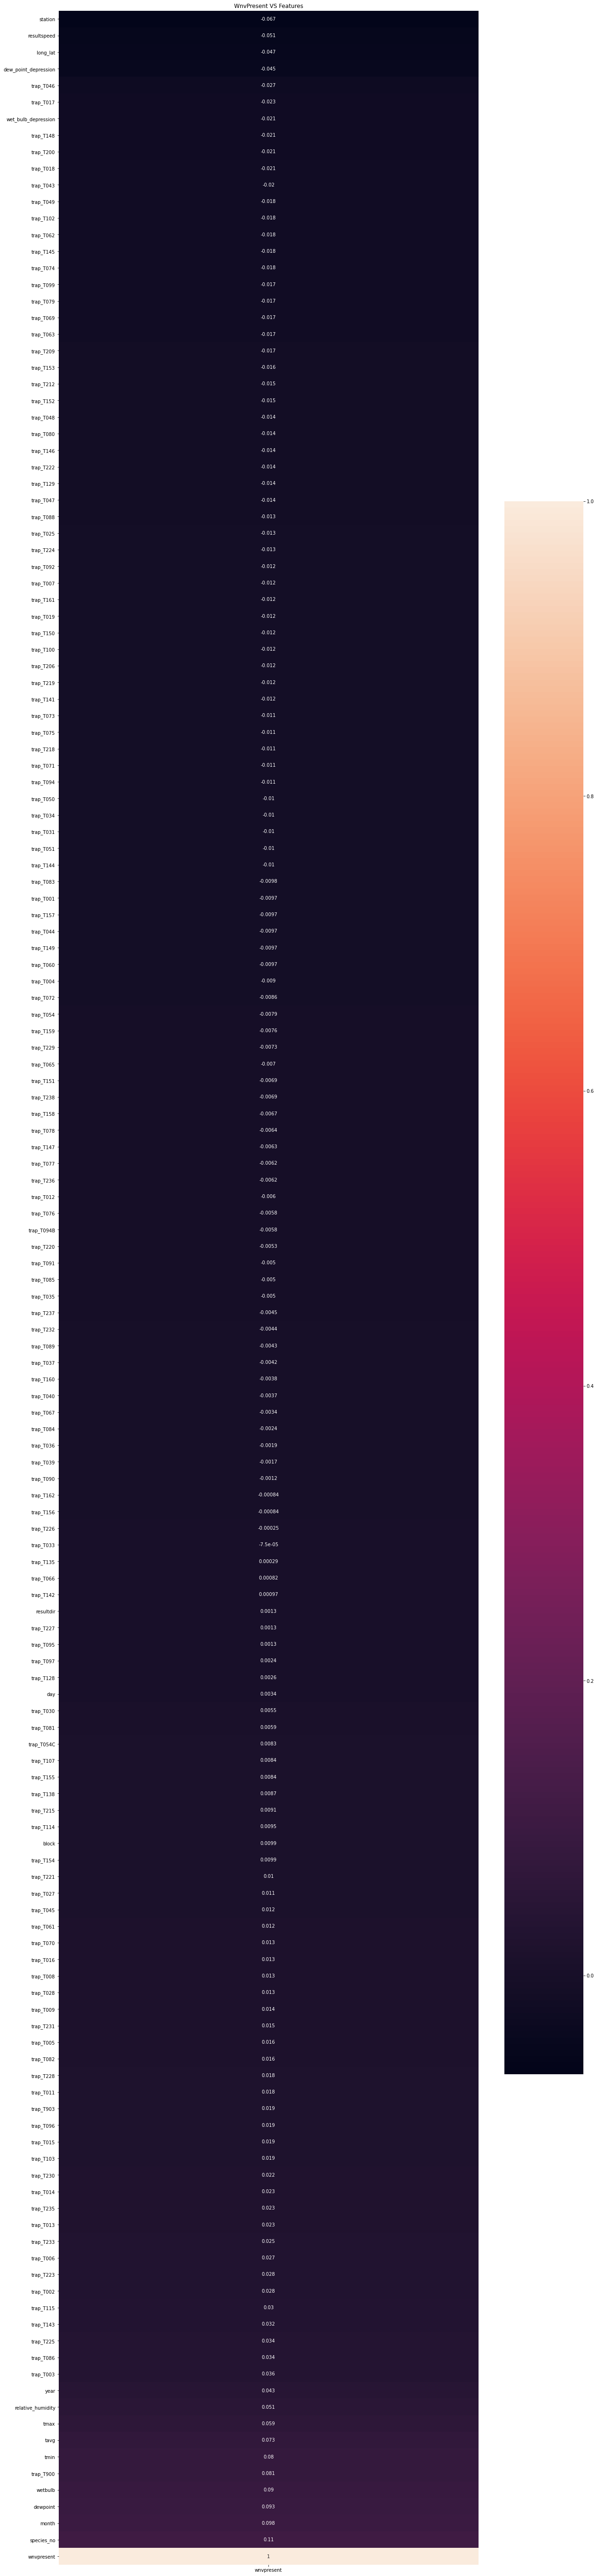

In [47]:
#Plotting the correlation heatmap again
plt.figure(figsize=(20,100))
sns.heatmap(combined_df.corr()[['wnvpresent']].sort_values('wnvpresent'), annot=True)
plt.title('WnvPresent VS Features')

In [48]:
# Finding top 40 correlated columns
corrmat = combined_df.corr()
cols = abs(corrmat['wnvpresent']).sort_values(ascending=False).head(41)
cols

wnvpresent              1.000000
species_no              0.108576
month                   0.097948
dewpoint                0.093440
wetbulb                 0.089656
trap_T900               0.080944
tmin                    0.080199
tavg                    0.073386
station                 0.066947
tmax                    0.058609
relative_humidity       0.051248
resultspeed             0.051165
long_lat                0.046969
dew_point_depression    0.044716
year                    0.043038
trap_T003               0.036012
trap_T086               0.034420
trap_T225               0.034122
trap_T143               0.031773
trap_T115               0.029565
trap_T002               0.028303
trap_T223               0.027643
trap_T046               0.026868
trap_T006               0.026601
trap_T233               0.025025
trap_T013               0.023042
trap_T235               0.022932
trap_T017               0.022860
trap_T014               0.022670
trap_T230               0.021912
wet_bulb_d

#Dropping unused features
combined_train_df = combined_df.drop(columns=['day_x','month_x','year_x','Unnamed: 0','Station', 'NumMosquitos', 
                                              'Species','Latitude','Longitude', 'day_y', 'month_y','year_y'])

In [49]:
combined_train_df = combined_df.drop(columns=['date'])
combined_train_df.head()

,day,month,year,wnvpresent,species,species_no,block,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,temp,daytime,dew_point_depression,wet_bulb_depression,relative_humidity,long_lat,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,29,5,2007,0,CULEX PIPIENS/RESTUANS,2.0,41,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3683.663359,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,29,5,2007,0,CULEX RESTUANS,1.0,41,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3683.663359,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,29,5,2007,0,CULEX RESTUANS,1.0,62,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3685.870082,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29,5,2007,0,CULEX PIPIENS/RESTUANS,2.0,79,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3686.366475,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,29,5,2007,0,CULEX RESTUANS,1.0,79,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3686.366475,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
#export to csv
combined_train_df.to_csv(r'../assets/combined_training.csv', index = False)

In [51]:
train = combined_train_df

In [52]:
train.head()

,day,month,year,wnvpresent,species,species_no,block,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,temp,daytime,dew_point_depression,wet_bulb_depression,relative_humidity,long_lat,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,29,5,2007,0,CULEX PIPIENS/RESTUANS,2.0,41,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3683.663359,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,29,5,2007,0,CULEX RESTUANS,1.0,41,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3683.663359,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,29,5,2007,0,CULEX RESTUANS,1.0,62,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3685.870082,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29,5,2007,0,CULEX PIPIENS/RESTUANS,2.0,79,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3686.366475,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,29,5,2007,0,CULEX RESTUANS,1.0,79,1,88,60,74,10,58,65,0,9,0 days 04:21:00,0 days 19:17:00,0.00,29.39,30.11,5.8,18,6.5,1900-01-01,0 days 14:56:00,16,9,57,-3686.366475,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Modelling

In [53]:
#!pip install imblearn

In [54]:
# import libraries
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_recall_fscore_support,  roc_auc_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [55]:
# decalre X and y
#features = train.columns.drop(['WnvPresent','Date'])

#features = train.columns.drop(['wnvpresent'])

#X = train[features]
X = train[[x for x in cols.index if x != 'wnvpresent']]
y = train['wnvpresent']

In [56]:
# Save X as csv file as reference for test dataset during Kaggle predictions.
#export to csv
X.to_csv(r'../assets/X_train.csv', index = False)

In [57]:
print(X.columns.tolist())

['species_no', 'month', 'dewpoint', 'wetbulb', 'trap_T900', 'tmin', 'tavg', 'station', 'tmax', 'relative_humidity', 'resultspeed', 'long_lat', 'dew_point_depression', 'year', 'trap_T003', 'trap_T086', 'trap_T225', 'trap_T143', 'trap_T115', 'trap_T002', 'trap_T223', 'trap_T046', 'trap_T006', 'trap_T233', 'trap_T013', 'trap_T235', 'trap_T017', 'trap_T014', 'trap_T230', 'wet_bulb_depression', 'trap_T148', 'trap_T200', 'trap_T018', 'trap_T043', 'trap_T103', 'trap_T015', 'trap_T096', 'trap_T903', 'trap_T011', 'trap_T049']


## Train-Test Split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.2, stratify=y)

The dataset it highly unbalanced, with WnVPositive at 95%. 
Creating a stratified train-test split to evaluate the models. 

In [59]:
X_train_col = X_train.columns

In [60]:
# PolyNomial with default degree=2
poly = PolynomialFeatures(include_bias=False)

X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

## Baseline Prediction


In [61]:
y_train.value_counts(normalize=True)

0    0.946313
1    0.053687
Name: wnvpresent, dtype: float64

Due to the imbalance of data, We will be 95% accurate if we predict all to be the negative class (WNV not present). We will be optimizing our models using AUC scores instead of accuracy. We will also deploy SMOTE (Synthetic Minority Over-sampling Technique) to help us with over-sampling.

In [62]:
# Scaling
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [63]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train_sc, y_train)

In [64]:
y_train_sm.value_counts()

0    1604
1    1604
Name: wnvpresent, dtype: int64

When using GridSearchCV to tune the hyperparameters, we will need to use imlearn.Pipeline to handle the samplers correctly.

### Define function to obtain model score


In [65]:
# create function to obtain model score
def get_score(model,Xtrain,ytrain, Xtest, ytest, predict):
    print('Model:', model.estimator )
    print('Gridsearch best score:', model.best_score_)
    print('Training best score:', model.score(Xtrain, ytrain))
    print('Testing best score:', model.score(Xtest, ytest))

In [66]:
# Initialize empty list to store all the scores and corresponding model names
model_name = []
model_scores = []
model_var = []
model_test_scores = []


### Model 01 Logistic Regression

In [67]:
# Pipeline
pipe_lr = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('lr', LogisticRegression(solver='newton-cg'))
    ])

pipe_lr.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(random_state=42)),
  ('lr', LogisticRegression(solver='newton-cg'))],
 'verbose': False,
 'sampling': SMOTE(random_state=42),
 'lr': LogisticRegression(solver='newton-cg'),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': 42,
 'sampling__sampling_strategy': 'auto',
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'newton-cg',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [68]:
# Hyperparameters
lr_params = {
    'lr__C': np.linspace(0.1,1,5),
}

In [69]:
# Instantiate 5-fold GridSearchCV.
gs_lr = GridSearchCV(pipe_lr, param_grid = lr_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_lr.fit(X_train_sc, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('lr',
                                        LogisticRegression(solver='newton-cg'))]),
             n_jobs=-1,
             param_grid={'lr__C': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
             scoring='roc_auc', verbose=1)

In [70]:
gs_lr.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('lr', LogisticRegression(C=0.1, solver='newton-cg'))])

In [71]:
lr = LogisticRegression(solver='newton-cg', C=0.1)
lr.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.1, solver='newton-cg')

### Logistic Regression Model Score 

In [72]:
# Append to the lists
model_name.append('Logistic Regression')
model_scores.append(lr.score(X_train_sm, y_train_sm))
model_var.append(lr)
model_test_scores.append(lr.score(X_test_sc,y_test))

### Intepret Logistic Regression

In [73]:
lr.coef_.shape

(1, 860)

In [74]:
## coefficient

importance = lr.coef_
features = poly.get_feature_names(X_train_col)
importance = importance.reshape(lr.coef_.shape[1],1)
imp_lr = pd.DataFrame(importance,
                       index=features,
                       columns=['weights']).sort_values(by='weights', ascending=False)
imp_lr

,weights
resultspeed wet_bulb_depression,0.779365
tmax relative_humidity,0.729250
station resultspeed,0.728258
resultspeed dew_point_depression,0.694250
species_no month,0.687420
...,...
dew_point_depression trap_T011,-0.578759
month resultspeed,-0.587473
month^2,-0.703581
resultspeed^2,-0.712824


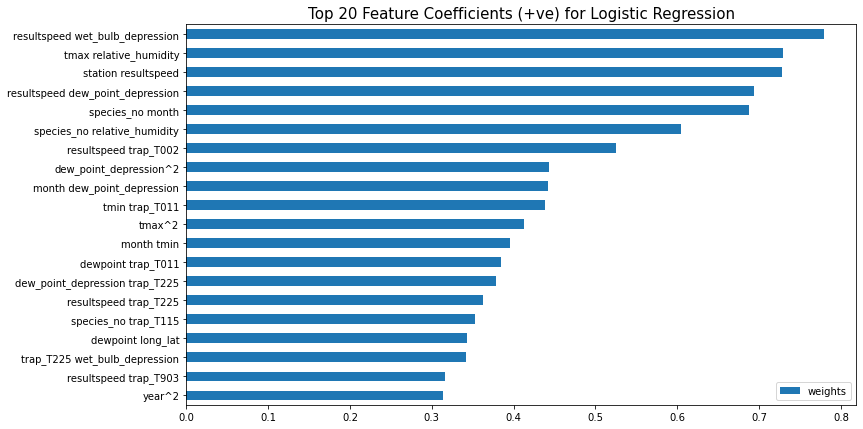

In [75]:
# Plotting top 20 +ve features in bar chart
imp_lr['weights'].head(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (+ve) for Logistic Regression', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

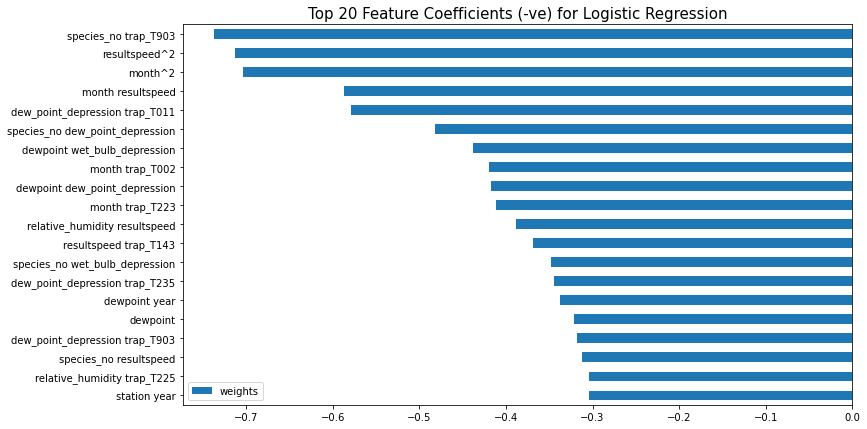

In [76]:
# Plotting top 20 -ve features in bar chart
imp_lr['weights'].tail(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (-ve) for Logistic Regression', fontsize=15)
plt.legend(loc=3);

### Model 02 Random Forest Classifier

In [77]:
#Fitting Random Forest Classifier
# Pipeline
pipe_rf = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ])

pipe_rf.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(random_state=42)),
  ('rf', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'sampling': SMOTE(random_state=42),
 'rf': RandomForestClassifier(random_state=42),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': 42,
 'sampling__sampling_strategy': 'auto',
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [78]:
# Hyperparameters
rf_params = {
    'rf__n_estimators': [80, 100, 120],
    'rf__max_depth': [3, 5],
    'rf__min_samples_leaf': [2, 4],
    'rf__min_samples_split' : [2, 4]
}

In [79]:
# Instantiate 5-fold GridSearchCV.
gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_rf.fit(X_train_sc, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5],
                         'rf__min_samples_leaf': [2, 4],
                         'rf__min_samples_split': [2, 4],
                         'rf__n_estimators': [80, 100, 120]},
             scoring='roc_auc', verbose=1)

In [80]:
gs_rf.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        n_estimators=80, random_state=42))])

In [81]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=120,
                       random_state=42)
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=120,
                       random_state=42)

In [82]:
# Append to the lists
model_name.append('Random Forest')
model_scores.append(rf.score(X_train_sm, y_train_sm))
model_var.append(rf)
model_test_scores.append(rf.score(X_test_sc,y_test))

### Model 03 ExtraTrees Classifier

In [83]:
# Pipeline
pipe_et = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('et', ExtraTreesClassifier(random_state=42))
    ])

pipe_et.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(random_state=42)),
  ('et', ExtraTreesClassifier(random_state=42))],
 'verbose': False,
 'sampling': SMOTE(random_state=42),
 'et': ExtraTreesClassifier(random_state=42),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': 42,
 'sampling__sampling_strategy': 'auto',
 'et__bootstrap': False,
 'et__ccp_alpha': 0.0,
 'et__class_weight': None,
 'et__criterion': 'gini',
 'et__max_depth': None,
 'et__max_features': 'auto',
 'et__max_leaf_nodes': None,
 'et__max_samples': None,
 'et__min_impurity_decrease': 0.0,
 'et__min_impurity_split': None,
 'et__min_samples_leaf': 1,
 'et__min_samples_split': 2,
 'et__min_weight_fraction_leaf': 0.0,
 'et__n_estimators': 100,
 'et__n_jobs': None,
 'et__oob_score': False,
 'et__random_state': 42,
 'et__verbose': 0,
 'et__warm_start': False}

In [84]:
# Hyperparameters
et_params = {
    'et__n_estimators': [80, 100, 120],
    'et__max_depth': [3, 5],
    'et__min_samples_leaf': [2, 4],
    'et__min_samples_split' : [2, 4]
}

In [85]:
# Instantiate 5-fold GridSearchCV.
gs_et = GridSearchCV(pipe_et, param_grid = et_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_et.fit(X_train_sc, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('et',
                                        ExtraTreesClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'et__max_depth': [3, 5],
                         'et__min_samples_leaf': [2, 4],
                         'et__min_samples_split': [2, 4],
                         'et__n_estimators': [80, 100, 120]},
             scoring='roc_auc', verbose=1)

In [86]:
gs_et.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('et',
                 ExtraTreesClassifier(max_depth=5, min_samples_leaf=2,
                                      random_state=42))])

In [87]:
et = ExtraTreesClassifier(max_depth=5, min_samples_leaf=4, n_estimators=80,
                     random_state=42)
et.fit(X_train_sm, y_train_sm)

ExtraTreesClassifier(max_depth=5, min_samples_leaf=4, n_estimators=80,
                     random_state=42)

In [88]:
# Append to the lists
model_name.append('Extra Trees')
model_scores.append(et.score(X_train_sm, y_train_sm))
model_var.append(et)
model_test_scores.append(et.score(X_test_sc,y_test))

In [89]:
imp_et = pd.DataFrame(et.feature_importances_,
                       index=features,
                       columns=['weights']).sort_values(by='weights', ascending=False)

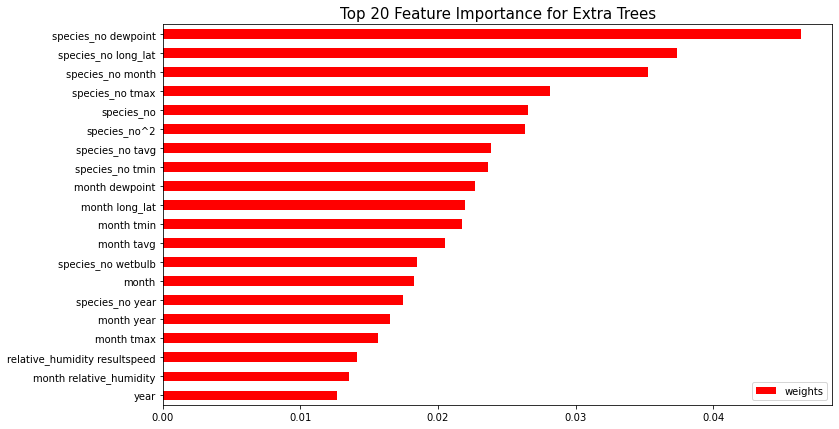

In [90]:
# Plotting top 20 +ve features in bar chart
imp_et.head(20).plot(kind='barh', label=imp_et.columns, figsize=(12,7), color='red')
plt.title('Top 20 Feature Importance for Extra Trees', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

### Model 04 AdaBoost Classifier

In [91]:
# Pipeline
pipe_ada = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('ada', AdaBoostClassifier(random_state=42))
    ])

pipe_ada.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(random_state=42)),
  ('ada', AdaBoostClassifier(random_state=42))],
 'verbose': False,
 'sampling': SMOTE(random_state=42),
 'ada': AdaBoostClassifier(random_state=42),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': 42,
 'sampling__sampling_strategy': 'auto',
 'ada__algorithm': 'SAMME.R',
 'ada__base_estimator': None,
 'ada__learning_rate': 1.0,
 'ada__n_estimators': 50,
 'ada__random_state': 42}

In [92]:
# Hyperparameters
ada_params = {
    'ada__n_estimators': [20, 30, 40, 50],
    'ada__learning_rate': [0.8, 0.9, 1]
}

In [93]:
# Instantiate 5-fold GridSearchCV.
gs_ada = GridSearchCV(pipe_ada, param_grid = ada_params, cv=5,
                      scoring='roc_auc', n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_ada.fit(X_train_sc, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('ada',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [0.8, 0.9, 1],
                         'ada__n_estimators': [20, 30, 40, 50]},
             scoring='roc_auc', verbose=1)

In [94]:
gs_ada.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('ada', AdaBoostClassifier(learning_rate=1, random_state=42))])

In [95]:
ada = AdaBoostClassifier(learning_rate=0.9, random_state=42)
ada.fit(X_train_sm, y_train_sm)

AdaBoostClassifier(learning_rate=0.9, random_state=42)

In [96]:
# Append to the lists
model_name.append('AdaBoost')
model_scores.append(ada.score(X_train_sm, y_train_sm))
model_var.append(ada)
model_test_scores.append(ada.score(X_test_sc,y_test))

In [97]:
imp_ada = pd.DataFrame(ada.feature_importances_,
                       index=features,
                       columns=['weights']).sort_values(by='weights', ascending=False)

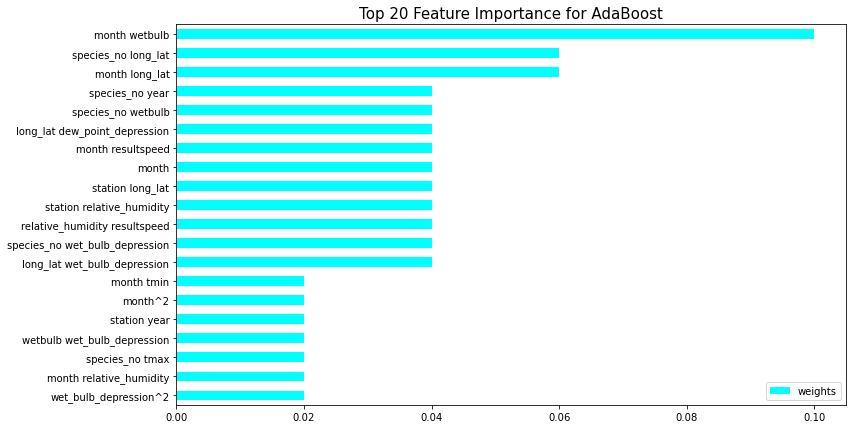

In [98]:
# Plot in bar chart
imp_ada.head(20).plot(kind='barh', label=imp_ada.columns[:20], figsize=(12,7), color='cyan')
plt.title('Top 20 Feature Importance for AdaBoost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

### Model 05 Gradient Boost Classifier

In [99]:
# Pipeline
pipe_gboost = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('gboost', GradientBoostingClassifier())
    ])

pipe_gboost.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(random_state=42)),
  ('gboost', GradientBoostingClassifier())],
 'verbose': False,
 'sampling': SMOTE(random_state=42),
 'gboost': GradientBoostingClassifier(),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': 42,
 'sampling__sampling_strategy': 'auto',
 'gboost__ccp_alpha': 0.0,
 'gboost__criterion': 'friedman_mse',
 'gboost__init': None,
 'gboost__learning_rate': 0.1,
 'gboost__loss': 'deviance',
 'gboost__max_depth': 3,
 'gboost__max_features': None,
 'gboost__max_leaf_nodes': None,
 'gboost__min_impurity_decrease': 0.0,
 'gboost__min_impurity_split': None,
 'gboost__min_samples_leaf': 1,
 'gboost__min_samples_split': 2,
 'gboost__min_weight_fraction_leaf': 0.0,
 'gboost__n_estimators': 100,
 'gboost__n_iter_no_change': None,
 'gboost__random_state': None,
 'gboost__subsample': 1.0,
 'gboost__tol': 0.0001,
 'gboost__validation_fraction': 0.1,
 'gboost__verbose': 0,
 'gboost__warm_start': False}

In [100]:
# Hyperparameters
gboost_params = {
    'gboost__n_estimators': [80, 100, 120, 150],
    'gboost__max_depth': [1, 2, 3],
    'gboost__min_samples_split': [2, 4],
    'gboost__min_samples_leaf': [1, 2]
}

In [101]:
# Instantiate 5-fold GridSearchCV.
gs_gboost = GridSearchCV(pipe_gboost, param_grid = gboost_params, cv=5,
                         scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_gboost.fit(X_train_sc, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('gboost',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gboost__max_depth': [1, 2, 3],
                         'gboost__min_samples_leaf': [1, 2],
                         'gboost__min_samples_split': [2, 4],
                         'gboost__n_estimators': [80, 100, 120, 150]},
             scoring='roc_auc', verbose=1)

In [102]:
gs_gboost.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('gboost',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=80))])

In [126]:
gboost = GradientBoostingClassifier(min_samples_leaf=2, n_estimators=80)
gboost.fit(X_train_sm, y_train_sm)

GradientBoostingClassifier(min_samples_leaf=2, n_estimators=80)

In [104]:
# Append to the lists
model_name.append('GradientBoosting')
model_scores.append(gboost.score(X_train_sm, y_train_sm))
model_var.append(gboost)
model_test_scores.append(gboost.score(X_test_sc, y_test))

In [105]:
imp_gboost = pd.DataFrame(gboost.feature_importances_,
                       index=features,
                       columns=['weights']).sort_values(by='weights', ascending=False)

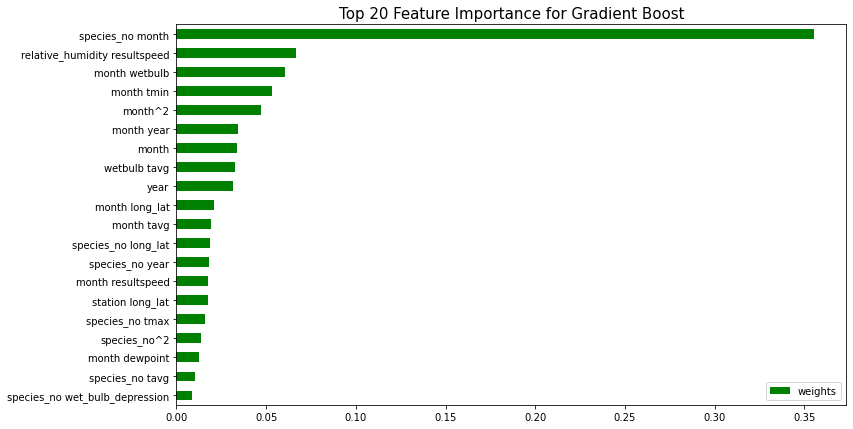

In [106]:
# Plot in bar chart
imp_gboost.head(20).plot(kind='barh', label=imp_gboost.columns[:20], figsize=(12,7), color='green')
plt.title('Top 20 Feature Importance for Gradient Boost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

### Model 06 SVM

In [107]:
# Pipeline
pipe_svc = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('svc', SVC())
    ])


pipe_svc.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(random_state=42)), ('svc', SVC())],
 'verbose': False,
 'sampling': SMOTE(random_state=42),
 'svc': SVC(),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': 42,
 'sampling__sampling_strategy': 'auto',
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [108]:

# Hyperparameters
svc_params = {
    'svc__C': [1, 0.1],
    'svc__kernel': ['rbf', 'poly'],
    'svc__degree': [2, 3]
}

In [109]:
# Instantiate 5-fold GridSearchCV.
gs_svc = GridSearchCV(pipe_svc, param_grid = svc_params, cv=5,
                      scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_svc.fit(X_train_sc, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 0.1], 'svc__degree': [2, 3],
                         'svc__kernel': ['rbf', 'poly']},
             scoring='roc_auc', verbose=1)

In [110]:
gs_svc.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('svc', SVC(C=1, degree=2))])

In [111]:
svc = SVC(C=0.1, degree=2)
svc.fit(X_train_sm, y_train_sm)

SVC(C=0.1, degree=2)

In [112]:
# Append to the lists
model_name.append('Support Vector Classifier')
model_scores.append(svc.score(X_train_sm, y_train_sm))
model_var.append(svc)
model_test_scores.append(svc.score(X_test_sc,y_test))

### Model Evaluation & SelectionModel Evaluation & Selection

In [113]:
# View the evaluation metrics for all models in a dataframe
# Sorted by highest F1-Score
precision_list = []
recall_list = []
fscore_list = []
auc_list_train = []
auc_list_test = []
for model in model_var:
    y_pred = model.predict(X_test_sc)
    y_pred_train = model.predict(X_train_sc)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)
    auc_list_train.append(roc_auc_score(y_train, y_pred_train))
    auc_list_test.append(roc_auc_score(y_test, y_pred))

pd.DataFrame({'Model Type': model_name,
              'Train AUC': auc_list_train,
              'Test AUC': auc_list_test,
              'F1-Score': fscore_list,
             'Recall': recall_list,
              'Precision': precision_list,
              'Train Accuracy': model_scores,
             'Test Accuracy': model_test_scores}).sort_values(by='F1-Score', ascending=False)

,Model Type,Train AUC,Test AUC,F1-Score,Recall,Precision,Train Accuracy,Test Accuracy
3,AdaBoost,0.782796,0.658550,0.587166,0.658550,0.570800,0.926434,0.860914
4,GradientBoosting,0.794487,0.674291,0.585625,0.674291,0.570438,0.914900,0.849263
1,Random Forest,0.811714,0.711152,0.557298,0.711152,0.561091,0.888092,0.784956
2,Extra Trees,0.812495,0.722152,0.537426,0.722152,0.556724,0.830736,0.744838
0,Logistic Regression,0.809299,0.638893,0.512745,0.638893,0.536702,0.830736,0.740855
5,Support Vector Classifier,0.731718,0.623479,0.460699,0.623479,0.526886,0.774626,0.636136


## Plotting ROC curves

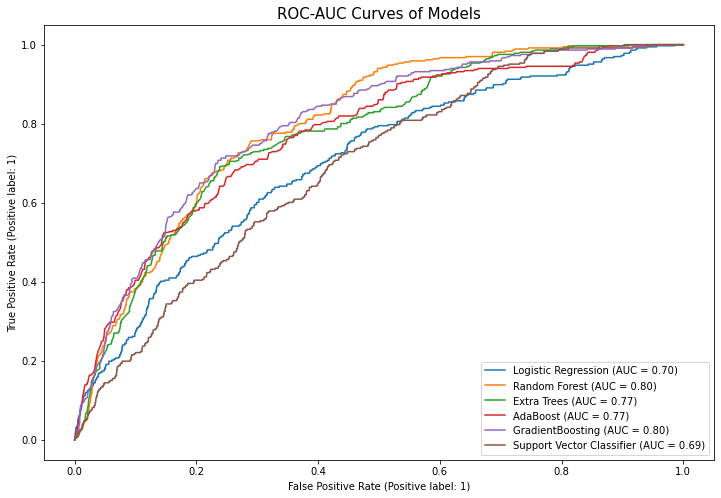

In [114]:
# Plotting the ROC curves for every model
plt.figure(figsize=(12,8))
ax = plt.gca()
for model, m_name in zip(model_var, model_name):
    plot_roc_curve(model, X_test_sc, y_test, name=m_name, ax=ax)
plt.title('ROC-AUC Curves of Models', fontsize=15);

ROC-AUC score is also useful to judge a model. It is useful to measure of how much the models are capable of distinguising the classes of 0 and 1. 
The higher the AUC, the better the model is at distinguishing between mosquito traps with Wnv present and Wnv NOT present. 

Based on the ROC-AUC graph above, we observed four models has high ROC-AUC which are the `AdaBoost`, and `GradientBoosting` with AUC score around 0.8. 

In [115]:
# Function to plot multiple confusion matrix
def subplot_confusion_matrix(model_list, model_name, X_test, y_test):
    nrows = int(np.ceil(len(model_list)/3))   # Ensure have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows*4))   
    plt.subplots_adjust(hspace = 0.4)
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    for i, model in enumerate(model_list):   # Gives us an index value to get into all our lists
        plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d', ax=ax[i])
        ax[i].set_title(model_name[i])
    
        # display scale and label only on the left edge
        if i%3 != 0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels('')
    # This code below is to switch off the axes if there is an odd number of subplots
    for axes in ax.flat[len(model_list):]:
        axes.axis('off')
    fig.tight_layout()
    pass

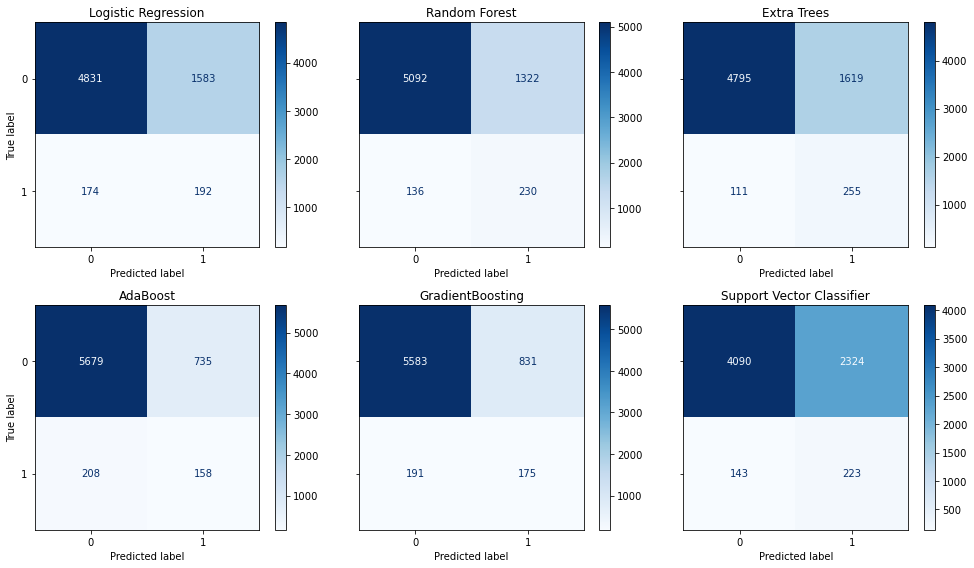

In [116]:
# Plotting confusion matrix for all models
subplot_confusion_matrix(model_var, model_name, X_test_sc, y_test)

### Interpretation

Due to the target variable is heavily imbalanced, judging the model's performance based on accuracy is not reliable. Instead, other metrics we can look at is the precision, recall, and F1-score. We decided to use F1-score as the deciding metrics for the model performance. By judging using F1-score able to achieve a balance between low false positives and false negatives. 

This is to lower the cost of spraying by spraying at the the location with false positives cases and to prevent missing out on spraying where the virus was actually present, which is the false negatives.

Based on the model, `AdaBoost` was selected as the best performing models based on it's high F1-score at 0.5871, higher AUC score at 0.80

### Assign the selected production model

In [127]:
# Assign the selected production model
production_model = ada

In [123]:
# Save polynomialfeatures as a pickle file
outfile = open('../assets/polyfeat.pkl','wb')
pickle.dump(poly, outfile)
outfile.close()

In [124]:
# Save scaler as a pickle file
outfile = open('../assets/scaler.pkl','wb')
pickle.dump(ss, outfile)
outfile.close()

In [128]:
# Save model as a pickle file
outfile = open('../assets/production_model.pkl','wb')
pickle.dump(production_model, outfile)
outfile.close()